In [1]:
# Based on https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from sklearn.decomposition import PCA
import scipy 

In [4]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import Callback

Using TensorFlow backend.


In [5]:
# Prepare data
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [6]:
# Reduce input dimensions
pca_components = 100

pca = PCA(n_components = pca_components)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print("Variance explained:", round(sum(pca.explained_variance_ratio_), 3))

Variance explained: 0.914


In [7]:
def getModel(hidden_layers = 1, neurons_per_layer = 512, input_dimension = 784):
    K.clear_session()
    
    model = Sequential()
    
    for i in range(hidden_layers):
        if i == 0:
            model.add(Dense(neurons_per_layer, input_shape = (input_dimension,), bias = False))
        else:
            model.add(Dense(neurons_per_layer, bias = False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

In [8]:
# Define model
model = getModel(hidden_layers = 4, neurons_per_layer = 100, input_dimension = pca_components)

model.summary()

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

W0822 14:37:43.117639  6956 deprecation_wrapper.py:119] From C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0822 14:37:43.118643  6956 deprecation_wrapper.py:119] From C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0822 14:37:43.165769  6956 deprecation_wrapper.py:119] From C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_shape=

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10000     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
__________

In [9]:
# # Fit and test
# history = model.fit(x_train_pca, y_train,
#                     batch_size = batch_size,
#                     epochs = epochs,
#                     verbose = 1,
#                     validation_data = (x_test_pca, y_test))
# score = model.evaluate(x_test_pca, y_test, verbose = 0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [10]:
class GraphSaver(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        
        G = nx.Graph()
        new_model = export_utils.copy_remove_batchnorm(self.model)
        layers = getLayers(new_model)
        weights, bias = getLayerWeights(layers)
        initialiseGraphNodes(layers, G, bias = bias)
        initialiseGraphEdges(weights, G)
        pos = getNodePositions(G, last_layer_multiplier = 1, last_layer = 5)
        drawPlot(G, pos, save_name = 'G1/{:02}'.format(epoch + 1))
        
        return

In [11]:
import export_utils

In [36]:
G = nx.Graph()

In [37]:
def getLayers(model):
    layers = {}
    layer_number = 1
    for layer in model.layers:
        if isinstance(layer, Dense):
            layers[layer_number] = layer
            layer_number += 1
    return layers

In [38]:
new_model = export_utils.copy_remove_batchnorm(model)
layers = getLayers(new_model)

In [39]:
layers

{1: <keras.layers.core.Dense at 0x21d3741f160>,
 2: <keras.layers.core.Dense at 0x21d688df400>,
 3: <keras.layers.core.Dense at 0x21d64e865f8>,
 4: <keras.layers.core.Dense at 0x21d66226278>,
 5: <keras.layers.core.Dense at 0x21d661aac88>}

In [40]:
def getLayerWeights(layers):
    weights = {}
    bias = {}
    for i in range(1,len(layers)+1):
        weight = layers[i].get_weights()
        if isinstance(weight, list):
            weights[i] = weight[0]
            bias[i] = weight[1]
        else:
            weights[i] = weight
    return weights, bias

In [41]:
weights, bias = getLayerWeights(layers)

In [42]:
def initialiseGraphNodes(layers, G, bias = None):
    for i, layer in layers.items():
        if i == 1:  # First hidden layer
            nodes = ["{}-{}".format(i-1, n) for n in range(layer.input_shape[1])]
            G.add_nodes_from(nodes)
        if bias is not None:
            nodes = [("{}-{}".format(i, n), {'bias': b}) for n, b in enumerate(bias[i])]
        else:
            nodes = ["{}-{}".format(i, n) for n in range(layer.units)]
        G.add_nodes_from(nodes)

In [43]:
initialiseGraphNodes(layers, G, bias = bias)

In [44]:
G.nodes

NodeView(('0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18', '0-19', '0-20', '0-21', '0-22', '0-23', '0-24', '0-25', '0-26', '0-27', '0-28', '0-29', '0-30', '0-31', '0-32', '0-33', '0-34', '0-35', '0-36', '0-37', '0-38', '0-39', '0-40', '0-41', '0-42', '0-43', '0-44', '0-45', '0-46', '0-47', '0-48', '0-49', '0-50', '0-51', '0-52', '0-53', '0-54', '0-55', '0-56', '0-57', '0-58', '0-59', '0-60', '0-61', '0-62', '0-63', '0-64', '0-65', '0-66', '0-67', '0-68', '0-69', '0-70', '0-71', '0-72', '0-73', '0-74', '0-75', '0-76', '0-77', '0-78', '0-79', '0-80', '0-81', '0-82', '0-83', '0-84', '0-85', '0-86', '0-87', '0-88', '0-89', '0-90', '0-91', '0-92', '0-93', '0-94', '0-95', '0-96', '0-97', '0-98', '0-99', '1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1

In [45]:
def initialiseGraphEdges(weights, G):
    edges = []
    for layer, weight in weights.items():
        rows, columns = weight.shape
        for i in range(rows):
            for j in range(columns):
                edge = ("{}-{}".format(layer-1, i), "{}-{}".format(layer, j), {'weight': weight[i,j]})
                edges.append(edge)
        
    G.add_edges_from(edges)

In [46]:
initialiseGraphEdges(weights, G)

In [47]:
def getNodePositions(G, last_layer_multiplier = 5, last_layer = None):
    pos = {}
    for node in G.nodes():
        split = node.split('-')
        layer = int(split[0])
        neuron = int(split[1])
        pos[node] = np.array( [layer, neuron * (last_layer_multiplier if layer == last_layer else 1)] )
    return pos

In [48]:
pos = getNodePositions(G, last_layer_multiplier = 10, last_layer = 5)

In [49]:
def getEdgeColour(G, threshold_by_value = None, threshold_by_fraction = None):
    edge_list = []
    edge_color = []
    for (u, v, w) in G.edges.data('weight'):
        if threshold_by_value is None or abs(w) > threshold_by_value:
            edge_list.append((u,v))
            edge_color.append(w)
    if threshold_by_fraction is not None:
        n = round(len(edge_list) * threshold_by_fraction)
        edge_color = np.array(edge_color)
        sort_order = np.argsort(np.abs(edge_color))
        edge_color = edge_color[sort_order[-n:]]
        edge_list = np.array(edge_list)[sort_order[-n:]]
        edge_color = edge_color.tolist()
        edge_list = edge_list.tolist()
    return edge_list, edge_color

In [50]:
def getNodeColour(G):
    node_color = []
    for (n, b) in G.nodes.data('bias'):
        if b is None:
            node_color.append(0)
        else:
            node_color.append(b)
    return node_color

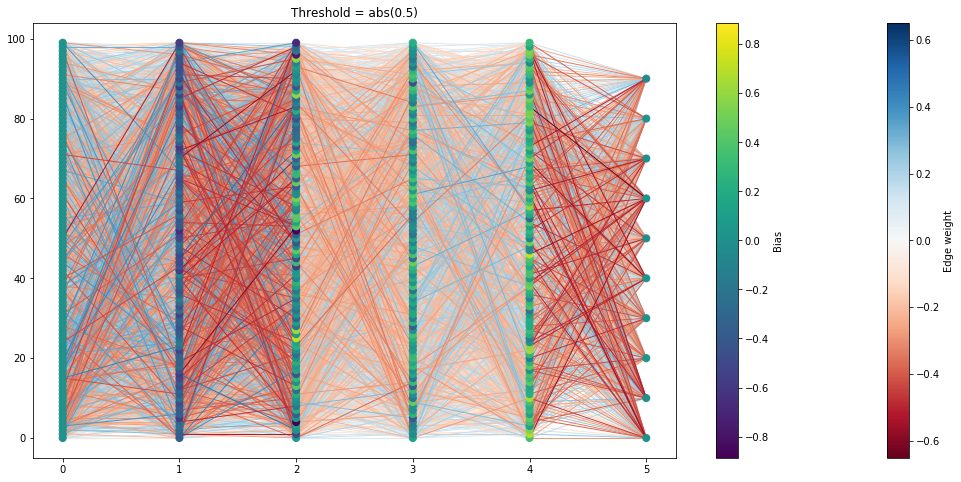

In [51]:
def drawPlot(G, pos, save_name = None, show_plot = False):
    fig, ax = plt.subplots(figsize = [18, 8])
    threshold = 0.5
    edge_list, edge_color = getEdgeColour(G, threshold_by_fraction = threshold)
    edge_cmap = plt.cm.RdBu
    edge_vmax = max(np.abs(edge_color))
    edge_vmin = -edge_vmax
    node_color = getNodeColour(G)
    node_cmap = plt.cm.viridis  # plt.cm.PRGn
    node_vmax = max(np.abs(node_color)) + 1E-12
    node_vmin = -node_vmax


    nx.draw_networkx(G, pos, with_labels = False, node_size = 50, edgelist = edge_list, edge_color = edge_color,
                     edge_cmap = edge_cmap, edge_vmin = edge_vmin, edge_vmax = edge_vmax, node_color = node_color,
                     cmap = node_cmap, vmax = node_vmax, vmin = node_vmin)
    sm = plt.cm.ScalarMappable(cmap = edge_cmap, norm = plt.Normalize(vmin = edge_vmin, vmax = edge_vmax))
    sm._A = []
    plt.colorbar(sm, label = 'Edge weight')
    sm_1 = plt.cm.ScalarMappable(cmap = node_cmap, norm = plt.Normalize(vmin = node_vmin, vmax = node_vmax))
    sm_1._A = []
    plt.colorbar(sm_1, label = 'Bias')
    plt.title("Threshold = abs({})".format(threshold))
    
    if save_name is not None:
        if not save_name.endswith('.png'):
            save_name += '.png'
        plt.savefig(save_name, dpi = 200)
    
    if show_plot:
        plt.show()
    
    plt.close()
    
drawPlot(G, pos, show_plot = True)

In [29]:
drawPlot(G, pos, save_name = 'G1/{:02}'.format(0))

[['0-1', '1-64'],
 ['2-0', '3-92'],
 ['0-34', '1-45'],
 ['3-95', '4-51'],
 ['3-22', '4-70'],
 ['0-99', '1-59'],
 ['3-76', '4-17'],
 ['0-29', '1-45'],
 ['1-87', '2-63'],
 ['3-81', '4-83'],
 ['2-57', '3-36'],
 ['3-31', '4-78'],
 ['3-39', '4-60'],
 ['3-2', '4-48'],
 ['0-26', '1-15'],
 ['2-1', '3-37'],
 ['0-81', '1-27'],
 ['1-73', '2-7'],
 ['3-43', '4-85'],
 ['2-94', '3-63'],
 ['0-19', '1-37'],
 ['1-29', '2-91'],
 ['0-10', '1-90'],
 ['3-9', '4-34'],
 ['0-98', '1-12'],
 ['0-14', '1-33'],
 ['1-9', '2-83'],
 ['3-54', '4-7'],
 ['1-56', '2-3'],
 ['1-13', '2-29'],
 ['2-63', '3-36'],
 ['3-19', '4-12'],
 ['0-9', '1-59'],
 ['3-30', '4-66'],
 ['0-60', '1-66'],
 ['3-97', '4-70'],
 ['1-79', '2-74'],
 ['2-52', '3-1'],
 ['1-20', '2-39'],
 ['0-85', '1-9'],
 ['2-16', '3-47'],
 ['1-66', '2-48'],
 ['1-97', '2-2'],
 ['0-87', '1-94'],
 ['2-33', '3-83'],
 ['1-11', '2-94'],
 ['3-53', '4-82'],
 ['3-36', '4-66'],
 ['2-41', '3-26'],
 ['0-37', '1-84'],
 ['3-2', '4-13'],
 ['0-14', '1-80'],
 ['2-55', '3-6'],
 ['1-5',

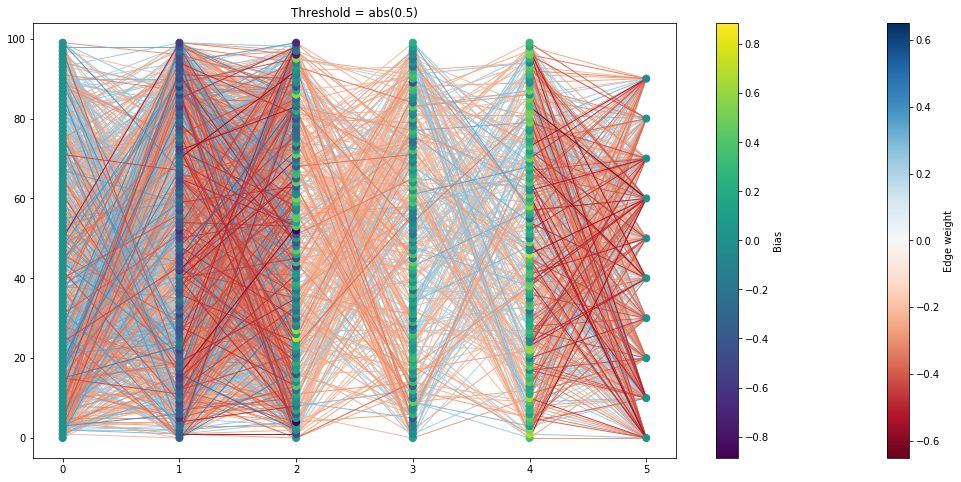

In [52]:
threshold=0.15
edge_list, edge_color = getEdgeColour(G, threshold_by_value = threshold)

G_Trained=G.edge_subgraph(edge_list)
drawPlot(G_Trained, pos, show_plot = True)

In [35]:
# Fit and test
graphSaver = GraphSaver()

history = model.fit(x_train_pca, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = [graphSaver],
                    validation_data = (x_test_pca, y_test))
score = model.evaluate(x_test_pca, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0822 14:42:22.996715  6956 deprecation.py:323] From C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.6839 - acc: 0.7854 - val_loss: 0.1947 - val_acc: 0.9394


C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Epoch 2/20
60000/60000 [==============================] - 2s 29us/step - loss: 0.3042 - acc: 0.9090 - val_loss: 0.1440 - val_acc: 0.9548
Epoch 3/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.2377 - acc: 0.9284 - val_loss: 0.1200 - val_acc: 0.9639
Epoch 4/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.2026 - acc: 0.9388 - val_loss: 0.1067 - val_acc: 0.9684
Epoch 5/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.1805 - acc: 0.9467 - val_loss: 0.0988 - val_acc: 0.9698
Epoch 6/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.1666 - acc: 0.9501 - val_loss: 0.0917 - val_acc: 0.9736
Epoch 7/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.1484 - acc: 0.9557 - val_loss: 0.0837 - val_acc: 0.9750
Epoch 8/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.1408 - acc: 0.9574 - val_loss: 0.0822 - val_acc: 0.9758
Epoch 9/20
60000/60000 [=================

In [53]:
adj=nx.adjacency_matrix(G_Trained,weight=None)
# adj=nx.adjacency_matrix(G_Untrained,weight=None)
ANNadj={"ANN_Adj_Mat_Trained":adj}

In [54]:
scipy.io.savemat("C:/Users/aloe8475/Documents/PhD/GitHub/CODE/Data/Inorganic Networks Connectomes/ANN_Adj_Trained", ANNadj)